In [1]:
import pandas as pd
import datetime
import sys, os
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
import talib
import ta
import shap
from coinmetrics.api_client import CoinMetricsClient
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
cfg = fin_utilities.__cfg_reading("pred")
import my_functions
import tensorflow as tf
import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR     = eval(cfg['PROJECT_PATH'])
DATA_PATH       = PROJECT_DIR / cfg['DATA_FOLDER']
DATASET_FOLDER  = PROJECT_DIR / cfg['DATASET_FOLDER']
SOURCE          = cfg['API_DATA_SOURCE']
URL             = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS         = cfg[SOURCE]['COLUMN_NAMES']
PARAMS          = cfg[SOURCE]['REQ_PARAMS']
SYMBOL          = cfg['SYMBOL']
STABLECOIN      = cfg['STABLECOIN']
PAIR            = SYMBOL + STABLECOIN #binance
MAX_LENGTH      = cfg['MAX_TRADE_DURATION']
XGB_PARAM       = cfg['xgb']
TRAIN_FILE      = cfg['TRAIN_FILE']
VALIDATION_FILE = cfg['VALIDATION_FILE']
TEST_FILE       = cfg['TEST_FILE']

c:\Users\ma.orlandi\Anaconda3\envs\obb\lib\site-packages\torch\onnx\_internal\_beartype.py:30: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")


In [2]:
df_train = pd.read_csv(DATASET_FOLDER/TRAIN_FILE) 
df_val = pd.read_csv(DATASET_FOLDER/VALIDATION_FILE) 
df_test = pd.read_csv(DATASET_FOLDER/TEST_FILE) 
df_train

,Time,Open_pct,High_pct,Low_pct,Close_pct,cons_green_candles,rolling_count,AVG_Candle_Price,Close_lag_13d,SMA_Close_13d,...,SMA_Close_99d,STD_Close_99d,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d,signal
0,2021-08-06 18:00:00,1.65,0.54,1.55,-0.94,-1.73,-1.0,-16.15,19.12,-3.33,...,-0.87,-1.72,14.96,-16.12,-16.54,1.26,-0.37,14.77,-16.20,1
1,2021-08-06 19:00:00,-1.12,1.46,0.41,1.09,1.41,1.0,-4.31,17.50,-6.00,...,1.00,-1.60,13.60,-4.43,21.04,-0.85,0.23,26.18,-4.23,1
2,2021-08-06 20:00:00,1.25,-1.08,-0.85,-0.86,0.00,0.0,-11.52,-20.34,-3.80,...,0.94,-2.44,-95.83,-11.56,-14.69,-0.55,-1.28,-60.43,-11.50,1
3,2021-08-06 21:00:00,-1.01,-0.16,1.22,0.56,0.00,-1.0,-7.12,-12.59,-2.48,...,-1.32,-2.59,-113.15,-6.99,12.66,-1.17,-1.38,-66.83,-7.02,1
4,2021-08-06 22:00:00,0.65,0.96,-0.64,1.19,0.00,1.0,14.14,4.90,2.72,...,-1.32,-1.08,15.11,14.20,9.36,-0.89,0.44,29.36,14.17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11124,2022-11-17 08:00:00,0.77,0.66,0.72,-0.77,-1.73,-1.0,3.31,-7.87,2.05,...,0.76,0.56,11.62,3.22,-3.18,0.60,0.52,24.68,3.25,0
11125,2022-11-17 09:00:00,-0.86,-0.75,-0.88,0.37,1.41,0.0,-8.33,7.80,-2.41,...,0.48,0.86,17.74,-8.34,-5.11,0.37,0.97,34.75,-8.34,0
11126,2022-11-17 10:00:00,0.53,0.67,1.03,0.82,0.00,1.0,5.68,-4.78,-1.25,...,0.66,0.62,12.75,5.64,-6.07,0.70,1.20,40.11,5.64,0
11127,2022-11-17 11:00:00,0.77,0.66,-0.59,-0.43,1.00,0.0,7.27,0.57,1.57,...,0.62,-0.39,-8.07,7.24,6.93,0.71,0.72,26.27,7.23,0


In [3]:
df_train['train_test']=0
df_val['train_test']=1
df_test['train_test']=2

df_analysis = pd.concat([df_train, df_val, df_test], axis=0, ignore_index=True)
df_analysis['YM'] = pd.to_datetime(df_analysis['Time']).dt.strftime('%Y%m')

df_analysis

,Time,Open_pct,High_pct,Low_pct,Close_pct,cons_green_candles,rolling_count,AVG_Candle_Price,Close_lag_13d,SMA_Close_13d,...,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d,signal,train_test,YM
0,2021-08-06 18:00:00,1.65,0.54,1.55,-0.94,-1.73,-1.00,-16.15,19.12,-3.33,...,14.96,-16.12,-16.54,1.26,-0.37,14.77,-16.20,1,0,202108
1,2021-08-06 19:00:00,-1.12,1.46,0.41,1.09,1.41,1.00,-4.31,17.50,-6.00,...,13.60,-4.43,21.04,-0.85,0.23,26.18,-4.23,1,0,202108
2,2021-08-06 20:00:00,1.25,-1.08,-0.85,-0.86,0.00,0.00,-11.52,-20.34,-3.80,...,-95.83,-11.56,-14.69,-0.55,-1.28,-60.43,-11.50,1,0,202108
3,2021-08-06 21:00:00,-1.01,-0.16,1.22,0.56,0.00,-1.00,-7.12,-12.59,-2.48,...,-113.15,-6.99,12.66,-1.17,-1.38,-66.83,-7.02,1,0,202108
4,2021-08-06 22:00:00,0.65,0.96,-0.64,1.19,0.00,1.00,14.14,4.90,2.72,...,15.11,14.20,9.36,-0.89,0.44,29.36,14.17,1,0,202108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16884,2023-07-18 19:00:00,-1.04,-1.13,-0.77,-1.00,-1.41,-1.41,-12.25,-8.24,1.58,...,37.91,-12.26,-5.72,-0.59,0.64,17.90,-12.23,0,2,202307
16885,2023-07-18 20:00:00,-0.93,-0.44,0.96,1.32,1.00,1.00,-5.53,6.52,-1.77,...,66.65,-5.67,-5.88,-0.57,0.76,21.34,-5.50,0,2,202307
16886,2023-07-18 21:00:00,1.33,1.07,-0.20,-0.96,1.00,0.00,10.74,6.65,1.53,...,72.04,10.44,4.21,0.40,-0.63,-16.99,10.73,0,2,202307
16887,2023-07-18 22:00:00,-0.97,-0.88,-0.63,0.33,0.00,1.00,-5.92,-4.39,1.06,...,17.72,-6.19,6.24,-0.46,0.17,5.93,-5.91,0,2,202307


In [4]:
import plotly.express as px

fig = px.histogram(df_analysis, x="YM",
             color='signal', barmode='group',
             height=400)
fig.show()

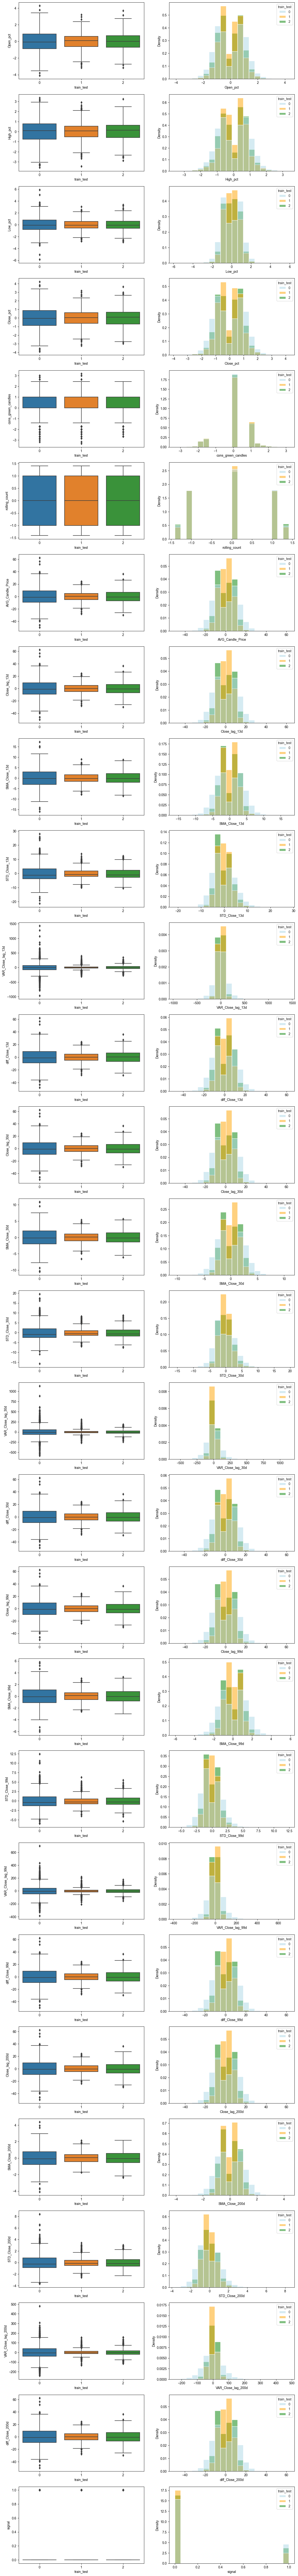

In [5]:
target_columns = [col for col in df_analysis.columns if col not in ['Time','YM','train_test']]
fig, axs = plt.subplots(figsize=(15,5*len(target_columns)), nrows=len(target_columns), ncols=2)

for i,col in enumerate([col for col in target_columns]):
    sns.set_style('whitegrid')
    sns.boxplot(y=col,data=df_analysis, ax=axs[i][0], x='train_test')
    #stat = ['count', 'frequency', 'density', 'probability', 'proportion', 'percent']
    sns.histplot(data=df_analysis, x=col, bins=20, ax=axs[i][1], hue='train_test', stat='density', common_norm=False, palette=['lightblue','orange','green'])

plt.show()

In [6]:
df_analysis.head()

,Time,Open_pct,High_pct,Low_pct,Close_pct,cons_green_candles,rolling_count,AVG_Candle_Price,Close_lag_13d,SMA_Close_13d,...,VAR_Close_lag_99d,diff_Close_99d,Close_lag_200d,SMA_Close_200d,STD_Close_200d,VAR_Close_lag_200d,diff_Close_200d,signal,train_test,YM
0,2021-08-06 18:00:00,1.65,0.54,1.55,-0.94,-1.73,-1.0,-16.15,19.12,-3.33,...,14.96,-16.12,-16.54,1.26,-0.37,14.77,-16.20,1,0,202108
1,2021-08-06 19:00:00,-1.12,1.46,0.41,1.09,1.41,1.0,-4.31,17.50,-6.00,...,13.60,-4.43,21.04,-0.85,0.23,26.18,-4.23,1,0,202108
2,2021-08-06 20:00:00,1.25,-1.08,-0.85,-0.86,0.00,0.0,-11.52,-20.34,-3.80,...,-95.83,-11.56,-14.69,-0.55,-1.28,-60.43,-11.50,1,0,202108
3,2021-08-06 21:00:00,-1.01,-0.16,1.22,0.56,0.00,-1.0,-7.12,-12.59,-2.48,...,-113.15,-6.99,12.66,-1.17,-1.38,-66.83,-7.02,1,0,202108
4,2021-08-06 22:00:00,0.65,0.96,-0.64,1.19,0.00,1.0,14.14,4.90,2.72,...,15.11,14.20,9.36,-0.89,0.44,29.36,14.17,1,0,202108


In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

df_merged = df_analysis[df_analysis['train_test'].isin([0,1])].reset_index(drop=True)

cols_to_drop = ['signal','YM','Time' #,'AVG_Candle_Price','VAR_Close_lag_10d'
               #'Close_lag_13d', 'SMA_Close_13d', 'STD_Close_13d', 'VAR_Close_lag_13d',
               #'Close_lag_30d', 'SMA_Close_30d', 'STD_Close_30d', 'VAR_Close_lag_30d',
               #'Close_lag_99d', 'SMA_Close_99d', 'STD_Close_99d', 'VAR_Close_lag_99d',
               #'Close_lag_200d', 'SMA_Close_200d', 'STD_Close_200d',
               #'VAR_Close_lag_200d'
                #,'tr_acs_pt_ip_exact_match', #'portali_ip_exact_match', 'tr_device'
                #,'tr_acs_pt_net_16_match','tr_acs_pt_net_24_match'
                
            ]

df_merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

all_data_shuffled = df_merged.copy() 
#all_data_shuffled.fillna(-9999,inplace=True)

# create our DMatrix (the XGBoost data structure)
y = all_data_shuffled[df_merged.columns[-1]]
X = all_data_shuffled[df_merged.columns[:-1]]

#split 80 20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# our XGBoost parameters
params = {'max_depth':4,
         'eta':.02,
         'subsample':.9,
         'colsample_bytree':.9,
         'objective':'binary:logistic',
         'eval_metric':'auc',
         'tree_method':'hist' } 

adv_val_model = xgb.train(
                        params=params,
                        dtrain=dtrain,
                        evals= [(dtrain, 'train') , (dval, 'valid')],
                        num_boost_round = 1000,
                        verbose_eval=10,
                        early_stopping_rounds=20
                )

[0]	train-auc:0.81920	valid-auc:0.77258
[10]	train-auc:0.87326	valid-auc:0.82560
[20]	train-auc:0.88258	valid-auc:0.83560
[30]	train-auc:0.89231	valid-auc:0.84976
[40]	train-auc:0.89672	valid-auc:0.85608
[50]	train-auc:0.90158	valid-auc:0.86276
[60]	train-auc:0.90535	valid-auc:0.86889
[70]	train-auc:0.90698	valid-auc:0.87086
[80]	train-auc:0.90887	valid-auc:0.87374
[90]	train-auc:0.91003	valid-auc:0.87529
[100]	train-auc:0.91130	valid-auc:0.87673
[110]	train-auc:0.91233	valid-auc:0.87800
[120]	train-auc:0.91336	valid-auc:0.87911
[130]	train-auc:0.91403	valid-auc:0.88008
[140]	train-auc:0.91492	valid-auc:0.88097
[150]	train-auc:0.91581	valid-auc:0.88176
[160]	train-auc:0.91658	valid-auc:0.88239
[170]	train-auc:0.91733	valid-auc:0.88325
[180]	train-auc:0.91804	valid-auc:0.88365
[190]	train-auc:0.91871	valid-auc:0.88385
[200]	train-auc:0.91933	valid-auc:0.88441
[210]	train-auc:0.92003	valid-auc:0.88462
[220]	train-auc:0.92059	valid-auc:0.88499
[230]	train-auc:0.92148	valid-auc:0.88579
[24

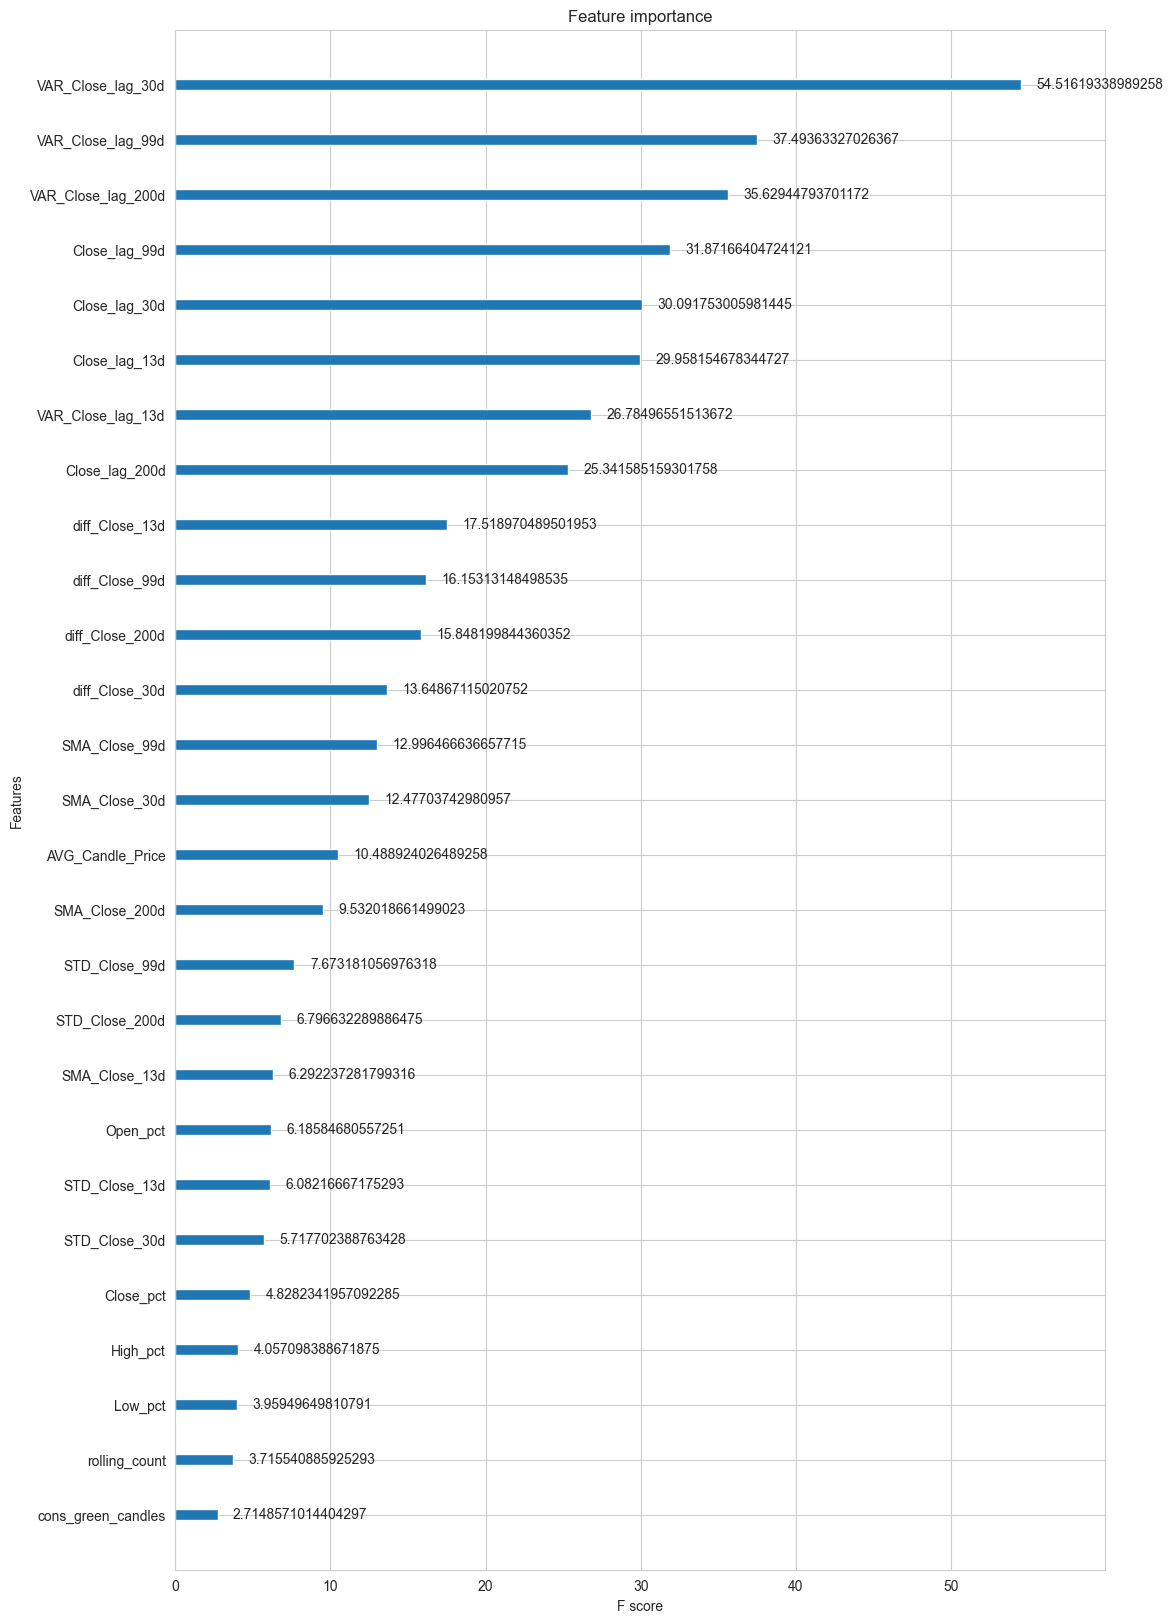

In [8]:
fig, ax = plt.subplots(figsize=(12,20)) 
plot_importance(adv_val_model, ax=ax, importance_type='gain')
plt.show()  

BUILD LSTM

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense,BatchNormalization
from keras.layers import Dropout, Activation
from keras import regularizers, initializers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.layers import TimeDistributed


df_train.drop(columns=['train_test','Time'], inplace=True, errors='ignore')
X_train = df_train[df_train.columns[:-1]]
Y_train = df_train['signal']

opt = tf.keras.optimizers.experimental.SGD() #learning_rate=.2, weight_decay=0)


model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1],1)))#, kernel_initializer=initializers.RandomNormal(stddev=0.1)))
model.add(LSTM(50, return_sequences=False, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
            optimizer=opt,
            loss=['binary_crossentropy'], 
            metrics=['AUC','accuracy']
)


early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, Y_train, batch_size=20, epochs=1000, validation_split=0.2, shuffle=False) #sample_weight_mode="temporal", sample)


# list all data in history
print(history.history.keys())
# summarize history for accuracy    
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Epoch 1/1000
446/446 [==============================] - 24s 40ms/step - loss: 0.5810 - auc: 0.4767 - accuracy: 0.7399 - val_loss: 0.4307 - val_auc: 0.4579 - val_accuracy: 0.8787
Epoch 2/1000
446/446 [==============================] - 19s 44ms/step - loss: 0.5745 - auc: 0.4825 - accuracy: 0.7423 - val_loss: 0.4298 - val_auc: 0.4549 - val_accuracy: 0.8787
Epoch 3/1000
446/446 [==============================] - 17s 38ms/step - loss: 0.5742 - auc: 0.4820 - accuracy: 0.7423 - val_loss: 0.4290 - val_auc: 0.4562 - val_accuracy: 0.8787
Epoch 4/1000
446/446 [==============================] - 16s 36ms/step - loss: 0.5739 - auc: 0.4820 - accuracy: 0.7423 - val_loss: 0.4283 - val_auc: 0.4541 - val_accuracy: 0.8787
Epoch 5/1000
446/446 [==============================] - 15s 33ms/step - loss: 0.5737 - auc: 0.4825 - accuracy: 0.7423 - val_loss: 0.4276 - val_auc: 0.4500 - val_accuracy: 0.8787
Epoch 6/1000
446/446 [==============================] - 15s 34ms/step - loss: 0.5735 - auc: 0.4827 - accuracy:

KeyboardInterrupt: 

In [17]:
y_pr = model.predict(X_train)
y_pr
    

505/505 [==============================] - 4s 6ms/step


array([[1.3968359e-07],
       [2.5722708e-04],
       [3.6357058e-05],
       ...,
       [1.0920076e-02],
       [9.7625101e-01],
       [3.9096796e-03]], dtype=float32)

In [32]:
model2 = Sequential()
model2.add(LSTM(units=512, kernel_initializer='random_normal', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.3))
model2.add(LSTM(256))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'AUC'])
model2.summary()

# Fit the model to the data
history = model2.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 22, 512)           1052672   
                                                                 
 dropout_8 (Dropout)         (None, 22, 512)           0         
                                                                 
 lstm_13 (LSTM)              (None, 256)               787456    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,906,177
Trainable params: 1,906,177
No

In [ ]:
model3 = Sequential()
model3.add(LSTM(1025, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model3.add(LSTM(256, return_sequences=True))
model3.add(LSTM(128, return_sequences=False))   
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

In [ ]:
model.fit(X_train, Y_train, epochs=10)

In [44]:
import numpy as np

# Assume your DataFrame is called df

# Step 1: Convert DataFrame to a numpy array
data = X_train
print(np.shape(X_train))
# Step 2: Define the window size, i.e., the number of time steps to look back
window_size = 24

# Step 3: Create empty lists to hold the inputs and outputs
X_train = []
Y_train = np.array(Y_train[window_size:])

# Step 4: Loop through the data and create the inputs and outputs
for i in range(window_size, len(data)):
    X_train.append(data[i-window_size:i])
#    y.append(data[len(features)-1][0])  # use the close price as the output variable

# Step 5: Convert the lists to numpy arrays
X_train = np.array(X_train)

# Step 6: Reshape the input data into a 3D tensor
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
#X_train = np.transpose(X_train, (0, 2,1))


#X_test = data[-(TEST_SIZE+window_size): , : ]
X_test = []
Y_test = np.array(Y_test)

# Step 4: Loop through the data and create the inputs and outputs
for i in range(len(data)-TEST_SIZE, len(data)):
    X_test.append(data[i-window_size:i])

X_test = np.array(X_test)
#X_test = np.transpose(X_test, (0, 2,1))

print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_test), np.shape(Y_test))



(16139, 22)
(16115, 24, 22) (16115,)
(720, 24, 22) (720,)


In [47]:


#model = Sequential()
#model.add(LSTM(50, return_sequences=True, kernel_regularizer=regularizers.l2(0.01),  kernel_initializer=initializers.RandomNormal(stddev=0.01), input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(200, return_sequences=False))
#model.add(Dense(25))
#model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.experimental.SGD(learning_rate=.2)

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

#model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='mse', optimizer=opt)

model.summary()

model.compile(optimizer=opt, loss=['binary_crossentropy'], metrics=['AUC','accuracy'])
history = model.fit(X_train, Y_train, batch_size=10, epochs=100, validation_batch_size=0.2, shuffle=False)


"""import tensorflow as tf

model = Sequential()
model.add(Bidirectional(
    LSTM(500, input_shape=(X_train.shape[1], X_train.shape[2]))
    )
)
model.add(LSTM(200, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.experimental.Adam(
    learning_rate=0.02), loss='mean_squared_error', metrics=['accuracy'])


model.fit(X_train, Y_train, batch_size= 30, epochs=50, shuffle=False)"""

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 20)            3440      
                                                                 
 lstm_9 (LSTM)               (None, 24, 50)            14200     
                                                                 
 lstm_10 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 37,891
Trainable params: 37,891
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1612/1612 [==============================] - 44s 24ms/step - loss: 0.6929 - auc: 0.5024 - accuracy: 0.5216
Epoch 2/100
1612/1612 [==============================] - 40s 25

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


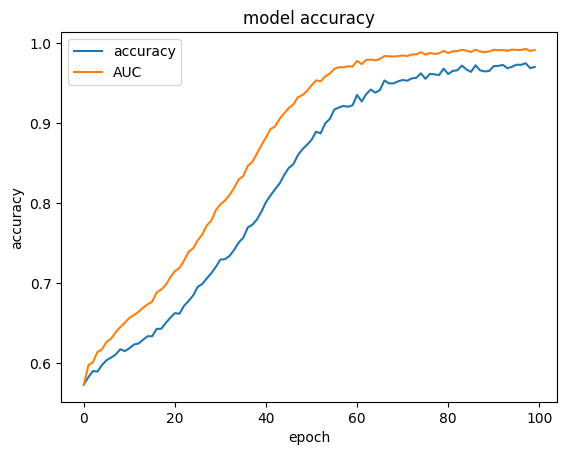

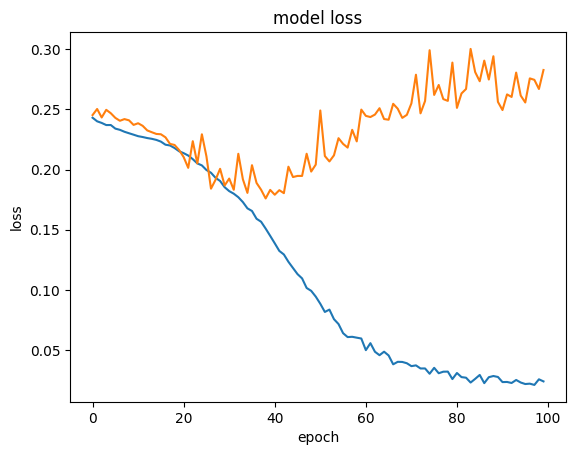

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy    
plt.plot(history.history['accuracy'])
plt.plot(history.history['auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'AUC'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
y_pr = model.predict(X_train)
y_pr

523/523 [==============================] - 7s 12ms/step


array([[0.46137884],
       [0.46136647],
       [0.46137354],
       ...,
       [0.46133852],
       [0.4612569 ],
       [0.46121606]], dtype=float32)

In [20]:
predictions = model.predict(X_test)
predictions = predictions[:,0]
predictions

23/23 [==============================] - 0s 8ms/step


array([4.62367535e-01, 2.40527660e-01, 8.22766066e-01, 9.36416669e-08,
       9.91647780e-01, 9.01434839e-01, 5.87249128e-03, 9.93281782e-01,
       5.78955514e-05, 9.93261099e-01, 9.93328452e-01, 8.18697501e-08,
       2.29652971e-02, 9.99999046e-01, 1.94596425e-01, 4.07232146e-04,
       9.97310102e-01, 1.68252771e-03, 9.99998808e-01, 9.87162232e-01,
       5.70634723e-01, 9.99974310e-01, 9.99227941e-01, 1.43323913e-01,
       3.86165222e-03, 9.38225925e-01, 5.20641565e-01, 1.65166017e-02,
       9.94368196e-01, 7.79206725e-03, 2.33892217e-01, 9.99992847e-01,
       9.99997377e-01, 1.17584341e-03, 3.58278930e-01, 7.12839095e-03,
       9.62902069e-01, 9.99999881e-01, 9.94640052e-01, 2.44185612e-01,
       6.82145417e-01, 2.75184284e-03, 9.99998391e-01, 1.49769783e-01,
       9.99608159e-01, 1.09477165e-04, 4.85749661e-06, 7.25006757e-05,
       8.96796167e-01, 7.09646894e-03, 2.71033078e-01, 5.15928134e-10,
       2.48569238e-04, 6.57115877e-02, 3.11642289e-01, 6.64973021e-01,
      

In [21]:
#predictions = (predictions-np.min(predictions))/(np.max(predictions)-np.min(predictions))

In [22]:
#my_functions.plt_correlation(train)

In [23]:
from sklearn.metrics import fbeta_score

best_precision = 0
thresh = 0
for i in np.arange(0.01, 1, 0.01):
    y_pred = [1 if el > i else 0 for el in predictions]
    #precision = sklearn.metrics.accuracy_score(Y_test, y_pred) # average='weighted', beta=.5)
    precision = sklearn.metrics.fbeta_score(Y_test, y_pred, average='weighted', beta=.5)
    if best_precision < precision:
        thresh = i 
        best_precision = precision

print(best_precision)
print(thresh)

0.5939001407580107
0.77


In [24]:
y_pred = [1 if el>thresh else 0 for el in predictions]

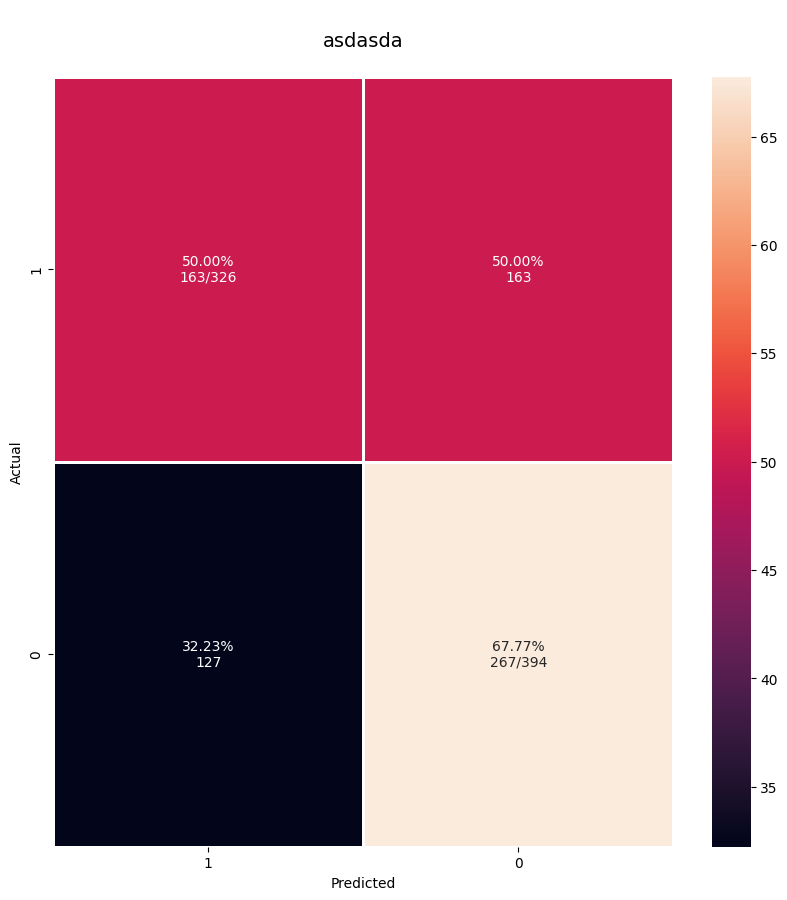

In [25]:
from sklearn.metrics import confusion_matrix

def cm_analysis(
    y_true, 
    y_pred, 
    title: str,
    filename: str, 
    labels: List[str], 
    ymap=None, 
    figsize=(10,10)
) -> None:
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.

    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      title:     plot name
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.

    Returns:
        None
    """

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', linewidths=1, ax=ax)
    plt.title('\n'+title+'\n', fontsize=14)
    plt.show()


cm_analysis(Y_test, y_pred,title='asdasda',filename='cm.png',labels=[1,0])

In [43]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(Y_test, predictions)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
print(auc_test)
#skplt.metrics.plot_roc(df_test['signal'],y_probas, title=f"ROC curve, AUC=test: {auc_test:.4f}", classes_to_plot=[1], figsize=(10,10))
#plt.show()

0.5302116786067194


In [ ]:
df.head()

In [ ]:
close_prices = df['price_close']
values = close_prices.values
training_data_len = int(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]



x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [ ]:

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

print(np.shape(x_train), np.shape(y_train))

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
print(np.shape(x_train), np.shape(y_train))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(np.shape(x_test), np.shape(y_test))

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

In [ ]:
data = df.filter(['price_close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price_close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
import numpy as np

# Assume your DataFrame is called df

# Step 1: Convert DataFrame to a numpy array
data = np.array(df[features])

# Step 2: Define the window size, i.e., the number of time steps to look back
window_size = 50

# Step 3: Create empty lists to hold the inputs and outputs
X = []
y = df['signal'][window_size:]

# Step 4: Loop through the data and create the inputs and outputs
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
#    y.append(data[len(features)-1][0])  # use the close price as the output variable

# Step 5: Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Step 6: Reshape the input data into a 3D tensor
X = np.reshape(X, (X.shape[0], X.shape[1], len(features)))
X2 = np.transpose(X, (0, 2,1))
print(np.shape(X), np.shape(y))
print(np.shape(X2))




In [ ]:
y

In [ ]:
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adagrad


model = Sequential()
model.add(LSTM(200, return_sequences=True, activation='relu', input_shape=(X2.shape[1],X2.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='rmsprop',    
              metrics=['accuracy']
            )

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X2, y, batch_size= 1, epochs=3)

In [ ]:
y_test = model.predict(X2)

In [ ]:
y_test